In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
from scipy.optimize import root
from scipy.misc import derivative

import sympy as sp
import fractions as fra

from ipywidgets import interact

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%run -i "rcParameters.py"
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"]='Times New Roman'
plt.rcParams["mathtext.fontset"]='stix';

In [3]:
# set fontsize in markdown cells
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

In [4]:
# find fixed poits FP and their stability sFP
# input: function f(x;r) ; initial guess for FPs; parameter r
# output: [Sfp=stable FPs, Ufp=unstable FPs]
def fP(f,fP0,r,eps=1e-6):
    sol=root(f,fP0,args=(r,))
    Sfp = []; Ufp = []
    if sol.success:
        for x in sol.x:
            xp = derivative(f,x,dx=eps,args=(r,))
            if xp < 0:
                Sfp = np.append(Sfp,x)
            else:
                Ufp = np.append(Ufp,x)
    return [Sfp,Ufp]

In [5]:
# Phase portrait:  interact plot f(x;r) 
def int_fxr(f,dx,dr,dy,eps=1e-6,nx=100,col='r',ms=10,title='',x_lab=r'$\theta$',y_lab=r'$\dot{\theta}$'):
    x = np.linspace(dx[0],dx[1],nx)
    f_ = lambda x,r: interpolate(x,f(x,r))
    @interact(r=(dr[0],dr[1],dr[2]),grid=True)
    def update(r=dr[0],grid=True):
        # plot f(x;r) vs x
        fig, ax = plt.subplots(figsize=(8,5))
        ax.plot(x,f(x,r),c=col,ls='-',lw=3)
        ax.set_ylim(dy)
        ax.set_xlim(dx)
        ax.set_xlabel(x_lab)
        ax.set_ylabel(y_lab)
        ax.axhline(0,dx[0],dx[-1],c='k',lw=1)
        ax.grid(grid)
        # determine the fixed points x*
        FP = f_(x,r).roots()
        # plot x* if exist
        for x0 in FP:
            sFP=derivative(f,x0,dx=eps,args=(r,))
            if sFP < 0: # stable PF
                ax.plot(x0,0,'o',mfc=col,mec=col,ms=ms)
            else:
                ax.plot(x0,0,'o',mfc='w',mec=col,ms=ms)

        ax.set_title(title,color='b')
        plt.show()        

In [6]:
# Phase portrait:  interact plot f(x;r) 
def int_fxr_V(f,dx,dr,dy,eps=1e-6,nx=100,col='r',ms=10,title='',x_lab=r'$\phi$',y_lab=r'V'):
    x = np.linspace(dx[0],dx[1],nx)
    f_ = lambda x,r: interpolate(x,f(x,r))
    @interact(r=(dr[0],dr[1],dr[2]),grid=True)
    def update(r=dr[0],grid=True):
        # plot f(x;r) vs x
        fig, ax = plt.subplots(figsize=(8,5))
        ax.plot(x,f(x,r),c=col,ls='-',lw=3)
        ax.set_ylim(dy)
        ax.set_xlim(dx)
        ax.set_xlabel(x_lab)
        ax.set_ylabel(y_lab)
        ax.axhline(0,dx[0],dx[-1],c='k',lw=1)
        ax.grid(grid)
        # determine the fixed points x*
        FP = f_(x,r).roots()
        # plot x* if exist
        for x0 in FP:
            sFP=derivative(f,x0,dx=eps,args=(r,))
            if sFP < 0: # stable PF
                ax.plot(x0,0,'o',mfc=col,mec=col,ms=ms)
            else:
                ax.plot(x0,0,'o',mfc='w',mec=col,ms=ms)

        ax.set_title(title,color='b')
        plt.show()        

In [7]:
# Bifurcation diagram: x vs r
def BF_diag(f,x1,x2,r1,r2,nx=800,nr=800,title='',x_lab='$r$',y_lab='$x^\star$'):
    fx = lambda x,r: derivative(f,x,dx=1e-6,args=(r,))
    x=np.linspace(x1,x2,nx)
    r=np.linspace(r1,r2,nr)
    R,X = np.meshgrid(r,x)
    Z = f(X,R)
    Zx= fx(X,R)
    Zu= np.ma.masked_where(Zx<0,Z)
    Zs= np.ma.masked_where(Zx>0,Z)
    fig, ax=plt.subplots()
    cnt_S=ax.contour(R,X,Zs,levels=[0],colors='k',linewidths=3)
    cnt_U=ax.contour(R,X,Zu,levels=[0],colors='k',linewidths=3,linestyles='dashed')
    ax.grid()
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    ax.set_title(title,color='b')
    plt.show()

In [8]:
# interactive Streamline plot: x(t;r)
def int_xtr(f,t_max,dx,dr,FP0,Ng=40,dens=[0.5,1],title=''):
    t = np.linspace(0,t_max,Ng)
    x = np.linspace(dx[0],dx[1],Ng)
    X,Y = np.meshgrid(t,x)
    @interact(r=(dr[0],dr[1],dr[2]),grid=False)
    def update(r=dr[0],grid=False):
        [Sx0,Ux0]=fP(f,FP0,r)
        # plot the slope field 
        fig, ax0=plt.subplots(figsize=(8,5))
        ax0.streamplot(X,Y, 1+0*X,f(Y,r),density=dens,
                      linewidth=1,color='k',arrowstyle='->')

        for x0 in Sx0:
            ax0.hlines(x0,0,t_max,colors='r',ls='-',lw=2)
        for x0 in Ux0:
            ax0.hlines(x0,0,t_max,colors='b',ls='--',lw=2)

        ax0.grid(grid)  
        ax0.set_xlim(0,t_max)
        ax0.set_ylim(dx)
        ax0.set_xlabel('$t$')
        ax0.set_ylabel('$\phi$')
        ax0.set_title(title,color='b')
        plt.show()

In [9]:
# set minor tick marks on/off; default on
def m_tick_on():
    plt.rcParams['xtick.minor.visible'] = True
    plt.rcParams['ytick.minor.visible'] = True
def m_tick_off():
    plt.rcParams['xtick.minor.visible'] = False
    plt.rcParams['ytick.minor.visible'] = False
    
m_tick_on()

interactive(children=(FloatSlider(value=-1.0, description='r', max=2.0, min=-1.0, step=0.5), Checkbox(value=Tr…

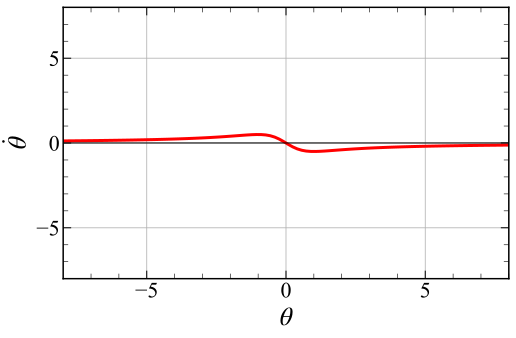

In [10]:
# 1ai
# define f(x;r)
f_tc = lambda x,r: r*x + (x**3)/(1+x**2)

# constract the interactive phase portrait 
dx = [-8,8]
dr = [-1,2,0.5] ; dy=[-8,8]
FS0= [-2,4]
int_fxr(f_tc,dx,dr,dy,FS0)

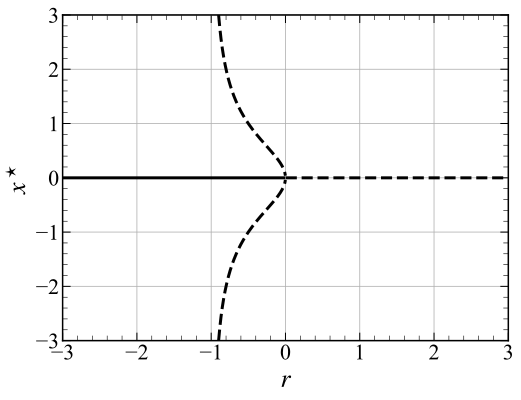

In [11]:
#1aii
BF_diag(f_tc,-3,3,-3,3)

In [30]:
int_xtr(f_tc,t_max=3.,dx=[-3.95,4],dr=[-2,2,0.5],FP0=[-2,2])

interactive(children=(FloatSlider(value=-2.0, description='r', max=2.0, min=-2.0, step=0.5), Checkbox(value=Fa…

In [12]:
# 1bi
# define f(x;r)
f_snp = lambda x,r: r-x-np.exp(-x)

# interactive phase portrait 
dx = [-20,60]
dr = [-3,2,0.2] ; dy=[-100,0]
FS0= [-1,1]
int_fxr(f_snp,dx,dr,dy,FS0)

interactive(children=(FloatSlider(value=-3.0, description='r', max=2.0, min=-3.0, step=0.2), Checkbox(value=Tr…

In [34]:
int_xtr(f_snp,t_max=3.,dx=[-3.95,4],dr=[-3,3,0.5],FP0=[-2,0,2])

interactive(children=(FloatSlider(value=-3.0, description='r', max=3.0, min=-3.0, step=0.5), Checkbox(value=Fa…

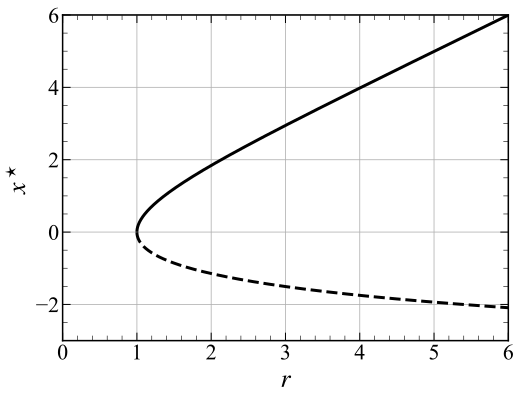

In [13]:
#1bii
BF_diag(f_snp,-3,6,0,6)

In [14]:
# 2a

# n' = GnN - kn; N' = -GnN-fn + = about 0
# p = GnN + fN = N(Gn+f); --> N = p/(Gn+f); --> n' = Gnp/(Gn+f)-kn

In [15]:
# 2b

# Fixed points at n' = 0 are n* = 0, (Gp-kf)/(kg);
# Stability analysis: dn'/dn = Gpf/f^2 - k = (Gp/kf - 1)k
# So n* = 0 is unstable for p > kf/G = p_crit

In [16]:
# 2c
# n' = -kn + Gp(n/f - Gn^2/f^2 + G^2n^3/f^3) = (-k + Gp/f)n - G^2p/f^2 * n^2 + O(n^3)
# This fits the general form for the transcritical bifurcation x' = rx - x^2.
# Setting -k + Gp/f = 0, solve for p, and we get the derived expression for p_crit.

In [17]:
# 2d
# From above, n' = GnN - kn; N' = -GnN-fn
# N' is approximately 0 in comparison to n' in the case that |Gn - k| >> |Gn + f|. 
# In a very brief relaxation period, N changes much more rapidly than n. After this period, as n changes, N 
# nearly instantly reaches a new equilibrium with n for its every instantaneous movement.

In [18]:
#3ai
# phase portrait
int_fxr(lambda x,r: r+np.sin(x)+np.cos(2*x),[-1.5*np.pi,1.5*np.pi],[-3,3,0.2],[-7,4])

interactive(children=(FloatSlider(value=-3.0, description='r', max=3.0, min=-3.0, step=0.2), Checkbox(value=Tr…

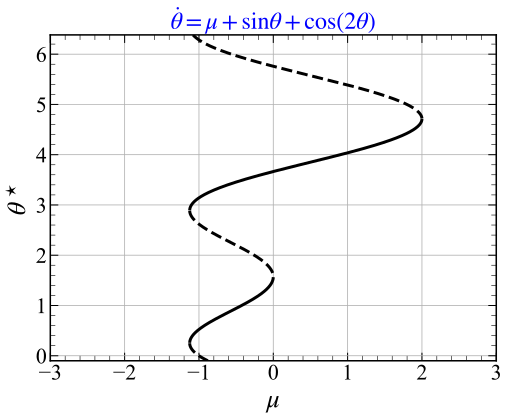

In [19]:
#3aii
# bifurcation diagram
# As mu varies, only saddle-node bifurcations appear. Based on bifurcation theory, two fixed points exist for mu <0,
# and one fixed points exists for mu = 0. At mu = -1, 0, there are fixed points. There appears to be a fixed point at
# mu = 2, though this is unsupported based on bifurcation theory as read in Strogatz.
BF_diag(lambda x,r: r+np.sin(x)+np.cos(2*x),-0.1,2*np.pi+0.1,-3,3,x_lab='$\mu$', y_lab=r'$\theta^\star$',
        title=r'$\dot\theta = \mu+\sin\theta+\cos(2\theta)$')

In [20]:
# 3bi
# phase portrait
int_fxr(lambda x,r: np.sin(2*x)/(1+r*np.sin(x)),[-0.5*np.pi,1.5*np.pi],[-3,3,0.2],[-7,4])

interactive(children=(FloatSlider(value=-3.0, description='r', max=3.0, min=-3.0, step=0.2), Checkbox(value=Tr…

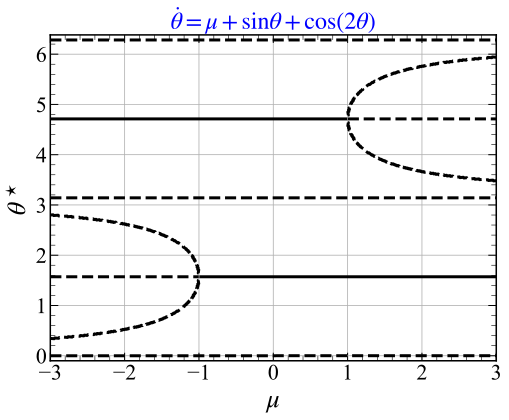

In [21]:
# 3bii
# bifurcation diagram. 
# As mu varies, oscillates between a supercritical pitchfork bifurcation and a 
# subcritical pitchfork bifurcation. Based on this diagram, the bifurcation points are located at mu = 1, -1
BF_diag(lambda x,r: np.sin(2*x)/(1+r*np.sin(x)),-0.1,2*np.pi+0.1,-3,3,x_lab='$\mu$', y_lab=r'$\theta^\star$',
        title=r'$\dot\theta = \mu+\sin\theta+\cos(2\theta)$')

In [22]:
# 4a
f_nuo = lambda x,a: a-np.sin(x)
f_ = lambda x,r: f_nuo(x,r)

In [23]:
# Supercurrent for a function of t, r = 1.10
# x(t;x0) as streamplot
int_xtr(f_,20,[0,4*np.pi],[1.1,8.1,1],[1.,3.,5.],title=r'4a Plot 1')

interactive(children=(FloatSlider(value=1.1, description='r', max=8.1, min=1.1, step=1.0), Checkbox(value=Fals…

In [24]:
# Supercurrent as a function of t, r = 6.1
# x(t;x0) as streamplot
int_xtr(f_,20,[0,4*np.pi],[8.1,9.1,1],[1.,3.,5.],title=r'4a Plot 2')

interactive(children=(FloatSlider(value=8.1, description='r', max=9.1, min=8.1, step=1.0), Checkbox(value=Fals…

In [ ]:
def f(c,x): return x**2 + c

ax = plt.subplot(1,1,1)
ax.set_xlim(-2,0)
ax.set_ylim(-2,2)
c_data = []
x_data = []
for c in np.linspace(-2,0,2000):
    x = 0.0
    for i in range(100):
        x = f(c,x)
    for i in range(500):
        x = f(c,x)
        c_data.append(c)
        x_data.append(x)
plt.plot(c_data,x_data,'k.', alpha=0.2, markersize=0.3)

ax.set_xticks([-2,-1.4,-1.25,-0.75,0])
ax.set_yticks([-2,2]);

fig = ax.figure
fig.set_figwidth(13)
fig.set_figheight(8)

In [38]:
int_fxr(lambda r,a: 1.1-np.sin(r),[0,30],[0,30,1],[-1,1])

interactive(children=(IntSlider(value=0, description='r', max=30), Checkbox(value=True, description='grid'), O…

In [25]:
# 4b; This instantaneous voltage diagram is enlarged by a factor of 10^16.
# phase portrait ()
f_nuo = lambda x,a: a-np.sin(x)
f_ = lambda x,r: 3.3*f_nuo(x,r)
int_fxr_V(f_,[-np.pi,np.pi],[1.1,8.1,1],[-2,10],title=r'4b Plot 1')

interactive(children=(FloatSlider(value=1.1, description='r', max=8.1, min=1.1, step=1.0), Checkbox(value=True…

In [26]:
# This instantaneous voltage diagram is enlarged by a factor of 10^16
# phase portrait ()
f_nuo = lambda x,a: a-np.sin(x)
f_ = lambda x,r: 3.3*f_nuo(x,r)
int_fxr_V(f_,[-np.pi,np.pi],[6.1,8.1,1],[-2,24],title=r'4b Plot 2')

interactive(children=(FloatSlider(value=6.1, description='r', max=8.1, min=6.1, step=1.0), Checkbox(value=True…